In [18]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


In [19]:
ticker = params.ticker
base_csv = params.base_csv

# 1) Glob all ticker-specific JSONs
pattern = os.path.join(params.optuna_folder, f"{ticker}_*.json")
files   = glob.glob(pattern)

# 2) Pick the one with the largest value in its filename
#     filenames are like "AAPL_0.603650.json"
best_file = max(
    files,
    key=lambda fn: float(os.path.basename(fn)
                              .replace(f"{ticker}_", "")
                              .replace(".json", ""))
)

# 3) Load it
with open(best_file) as fp:
    best_record = json.load(fp)

best_value  = best_record["value"]
best_params = best_record["params"]

# print(f"Using best Optuna trial {best_value:.6f}:")

# # adjust the best_params dictionary with exactly the hyperparameters that the function run_trading_pipeline needs

# minutes_total = (params.regular_start.hour * 60 + params.regular_start.minute)

# look_back = best_params.pop("look_back")

# regular_start_pred = dt.time(*divmod(minutes_total - look_back, 60))
# regular_start_shifted_more = dt.time(*divmod(minutes_total - (look_back*2 + 30), 60)) # adding additional 30 minutes to calculate the features indicators afterwards

# best_params["regular_start_shifted"] = regular_start_shifted_more 

best_value, best_params

(0.7212614814814814,
 {'min_prof_thr': 0.16151431153470566,
  'max_down_prop': 0.03127603427729314,
  'gain_tightening_factor': 1.0151446858760491,
  'merging_retracement_thr': 0.05428541398603447,
  'merging_time_gap_thr': 1.1741680182401633,
  'pre_entry_decay': 0.07671412333991255,
  'short_penal_decay': 0.5543741455477247,
  'trailing_stop_pct': 0.030047512007573288,
  'buy_threshold': 0.7232246343903865,
  'top_percentile': 7.293688122899983})

[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


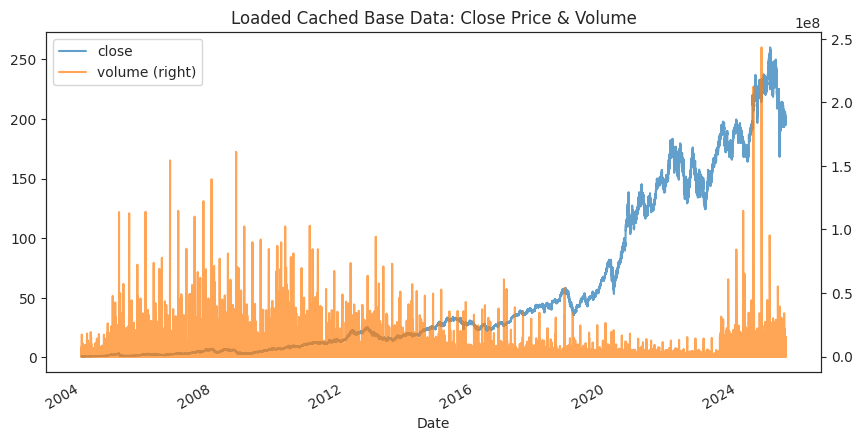

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764857    0.763714  
2004-01-02 09:01:00     28000.0    0.764857    0.763714  
2004-01-02 09:02:00     28000.0    0.764857    0.763714  
2004-01-02 09:03:00     28000.0    0.764857    0.763714  
2004-01-02 09:04:00     28000.0    0.764857    0.763714  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.962600  196.667400  
2025-06-18 20:57:00    460630.0  196.822500  196.527500  
2025-06-18 20:58:00    525245.0  196.817500  196.522500  
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  

[3893400 rows x 7 columns]

In [20]:

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [27]:
def process_single_day(day_str: str, hyperparams: dict):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same hyperparams
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal',
                                        col_action               = 'signal_action',
                                        day_to_check             = day_str,
                                        **hyperparams            # unpack tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = hyperparams['buy_threshold'],
                    performance_stats  = perf_day,
                    start_plot         = params.sess_start # or sess_premark 
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [28]:
def saveDF_checkDAY(df: pd.DataFrame, hyperparams: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., hyperparams)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **hyperparams
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save the dataframe with the calculated signal
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass hyperparams into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 hyperparams = hyperparams)
        
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack hyperparams into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **hyperparams
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all



Month mode: processing 2025-05

=== Processing trading day 2025-05-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


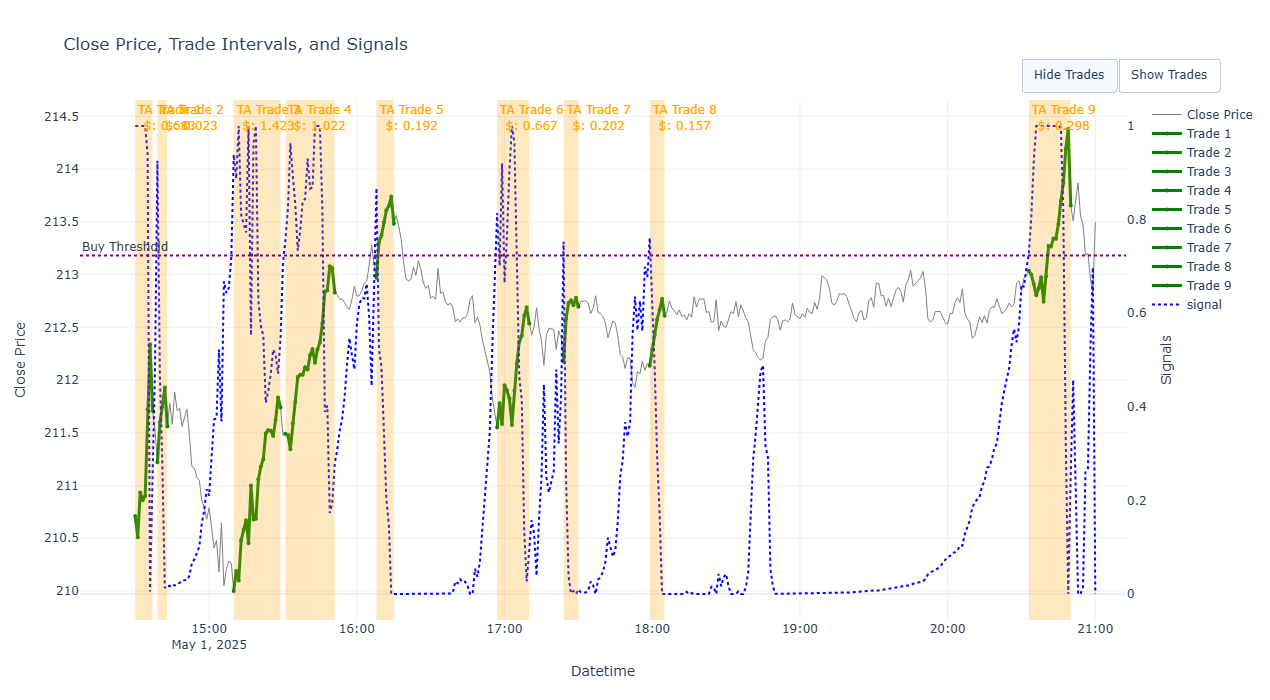


* Performance for 2025-05-01 *
  Buy & Hold Return ($): 2.472
  Strategy Return ($): 4.667
  Trades Returns ($): [0.683, 0.023, 1.423, 1.022, 0.192, 0.667, 0.202, 0.157, 0.298]

=== Processing trading day 2025-05-02 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


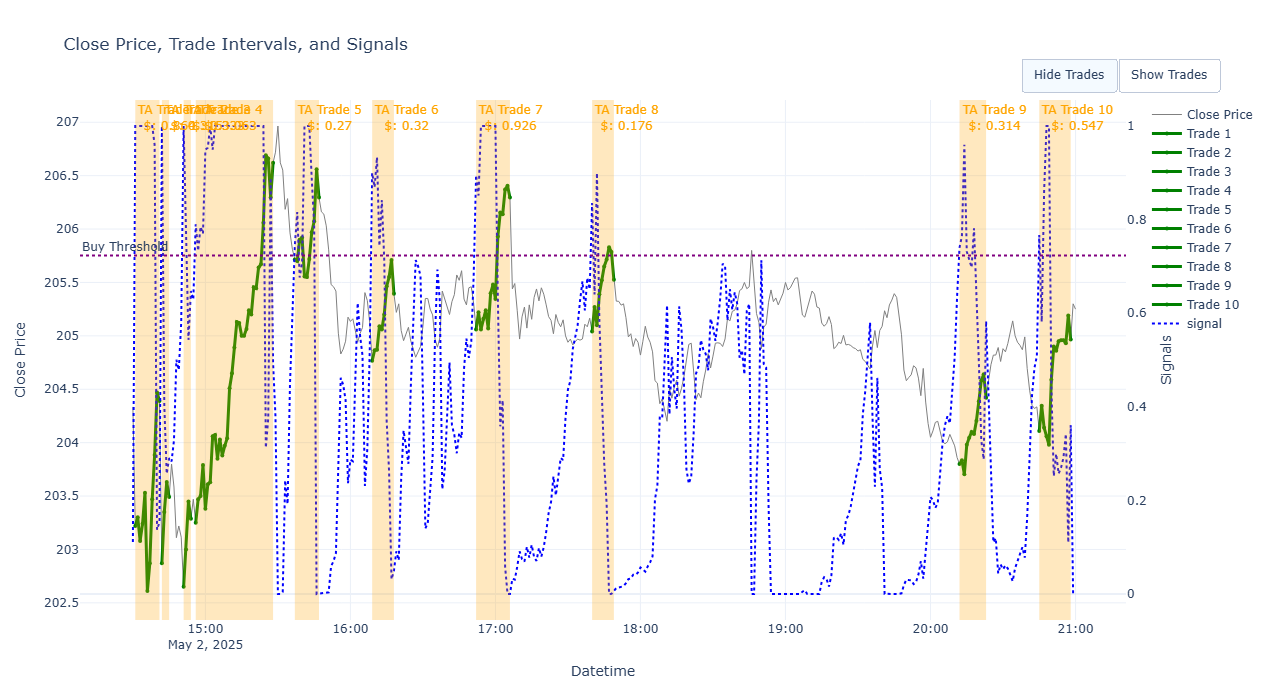


* Performance for 2025-05-02 *
  Buy & Hold Return ($): 0.608
  Strategy Return ($): 7.131
  Trades Returns ($): [0.864, 0.315, 0.333, 3.063, 0.27, 0.32, 0.926, 0.176, 0.314, 0.547]

=== Processing trading day 2025-05-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


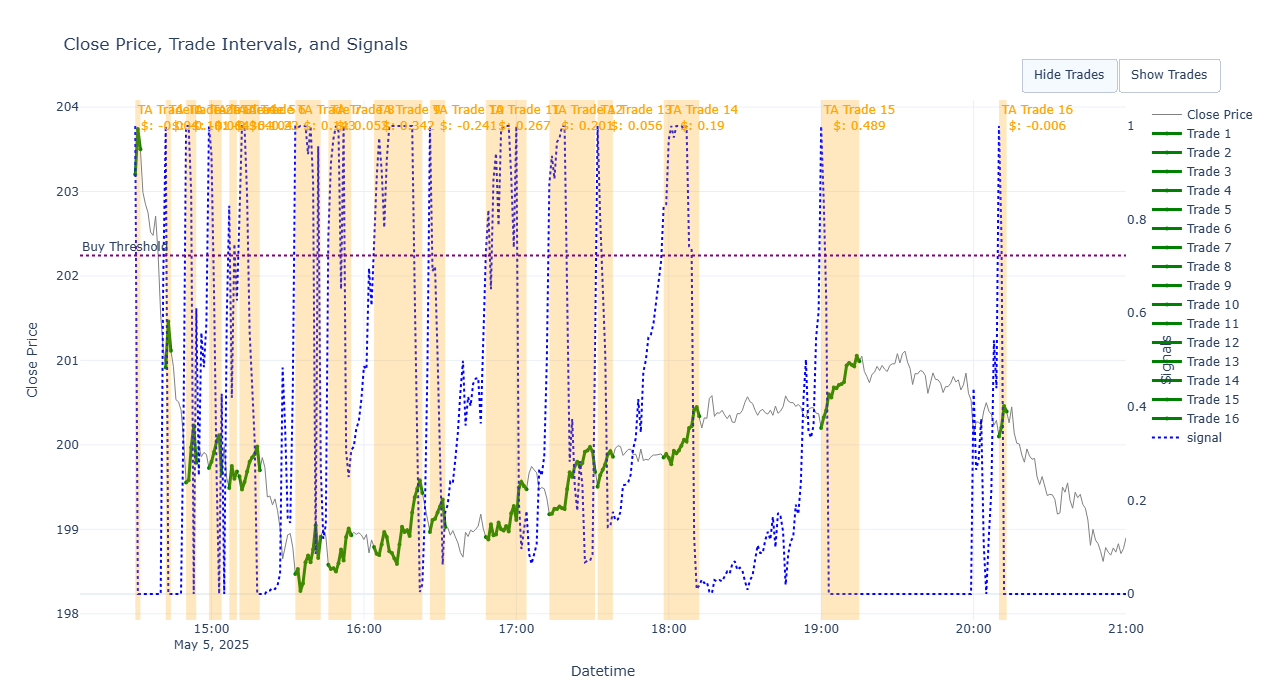


* Performance for 2025-05-05 *
  Buy & Hold Return ($): -4.601
  Strategy Return ($): 0.623
  Trades Returns ($): [-0.004, -0.101, -0.064, -0.364, -0.104, -0.23, 0.143, 0.052, 0.342, -0.241, 0.267, 0.201, 0.056, 0.19, 0.489, -0.006]

=== Processing trading day 2025-05-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


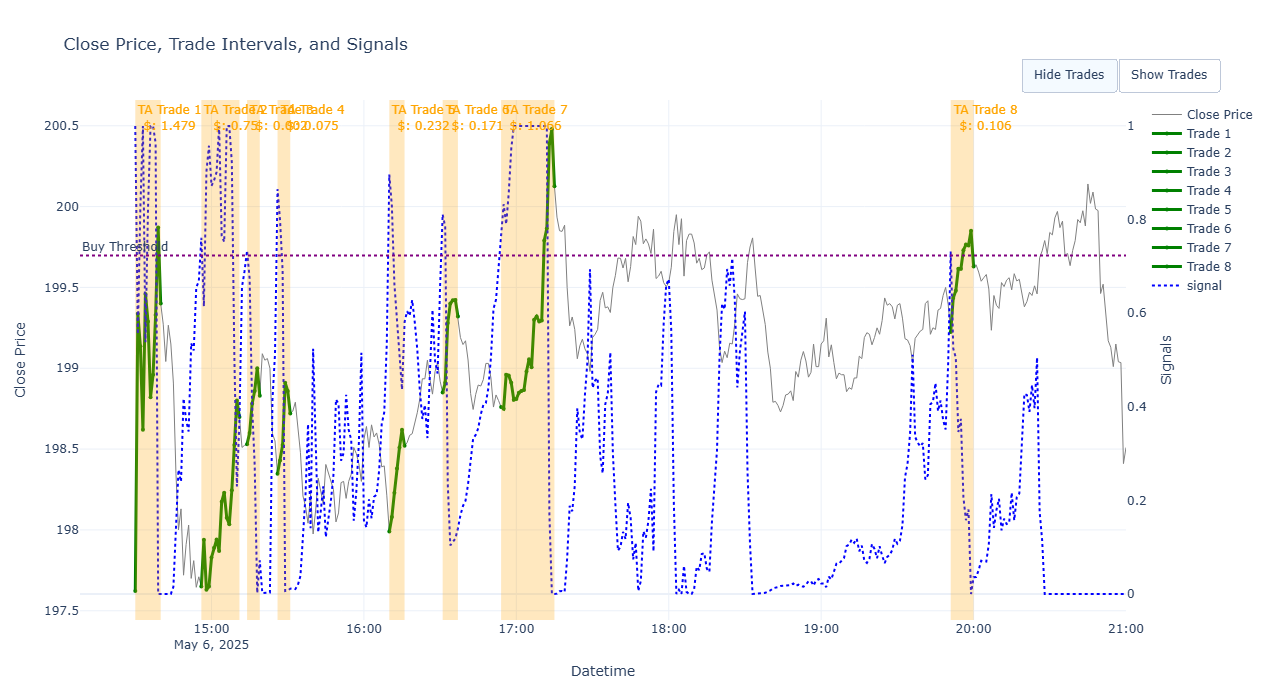


* Performance for 2025-05-06 *
  Buy & Hold Return ($): 0.591
  Strategy Return ($): 3.884
  Trades Returns ($): [1.479, 0.75, 0.002, 0.075, 0.232, 0.171, 1.066, 0.106]

=== Processing trading day 2025-05-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


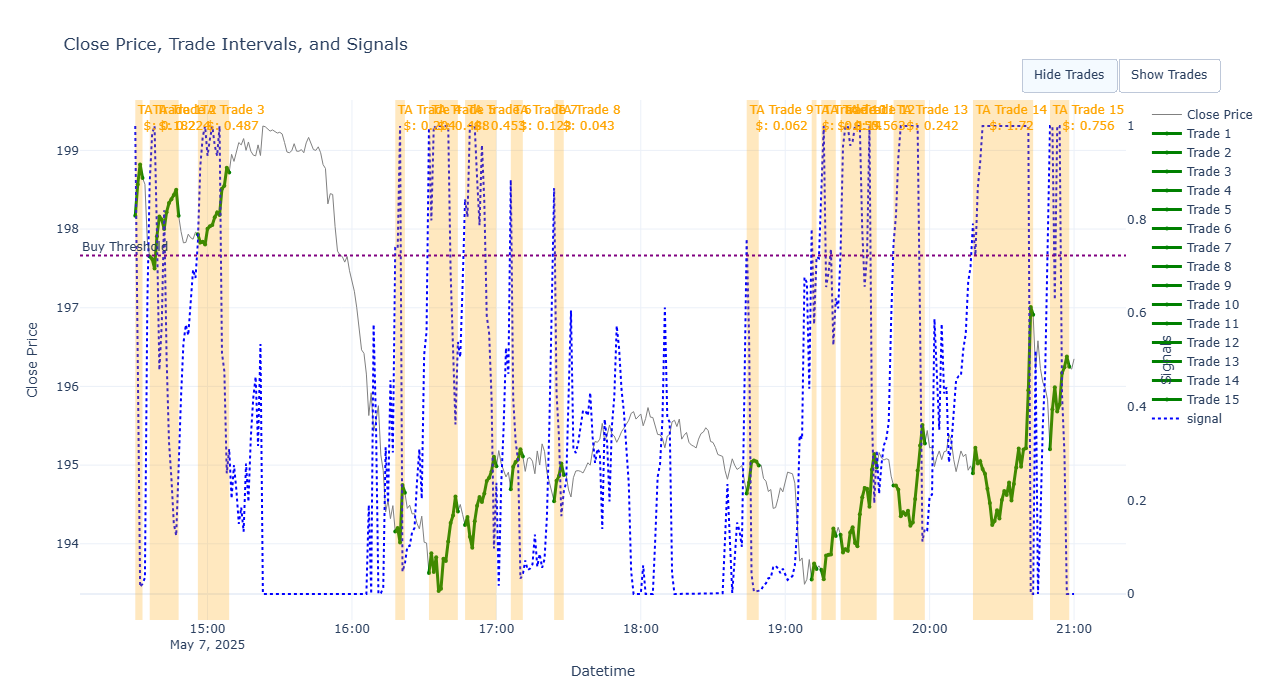


* Performance for 2025-05-07 *
  Buy & Hold Return ($): -2.116
  Strategy Return ($): 5.534
  Trades Returns ($): [0.182, 0.224, 0.487, 0.204, 0.488, 0.453, 0.123, 0.043, 0.062, -0.155, 0.14, 0.563, 0.242, 1.72, 0.756]

=== Processing trading day 2025-05-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


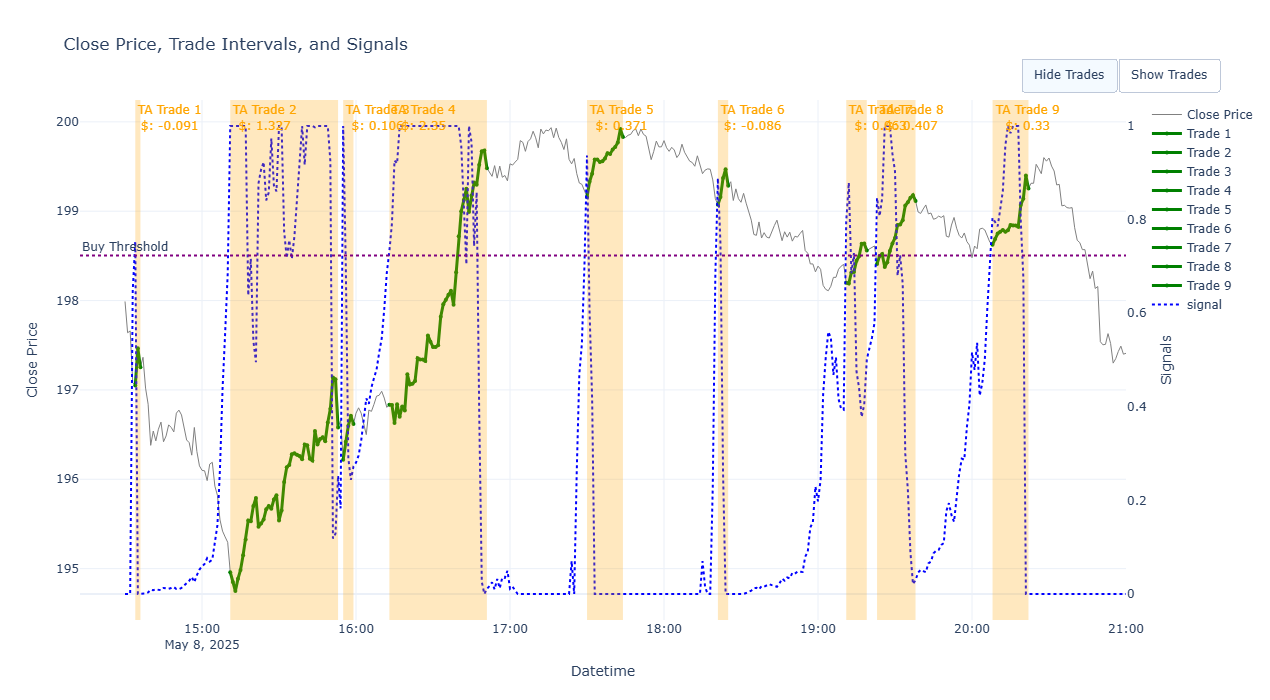


* Performance for 2025-05-08 *
  Buy & Hold Return ($): -0.877
  Strategy Return ($): 4.776
  Trades Returns ($): [-0.091, 1.327, 0.106, 2.35, 0.371, -0.086, 0.063, 0.407, 0.33]

=== Processing trading day 2025-05-09 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


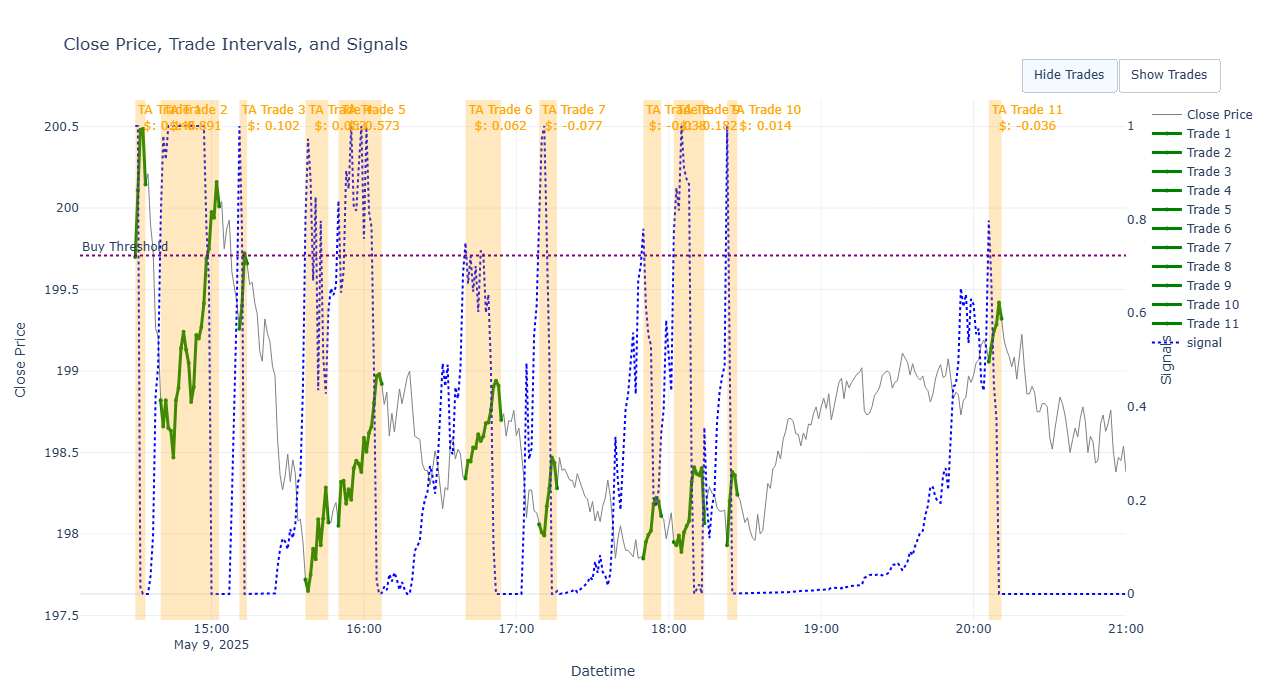


* Performance for 2025-05-09 *
  Buy & Hold Return ($): -1.619
  Strategy Return ($): 1.505
  Trades Returns ($): [0.146, 0.891, 0.102, 0.053, 0.573, 0.062, -0.077, -0.038, -0.182, 0.014, -0.036]

=== Processing trading day 2025-05-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


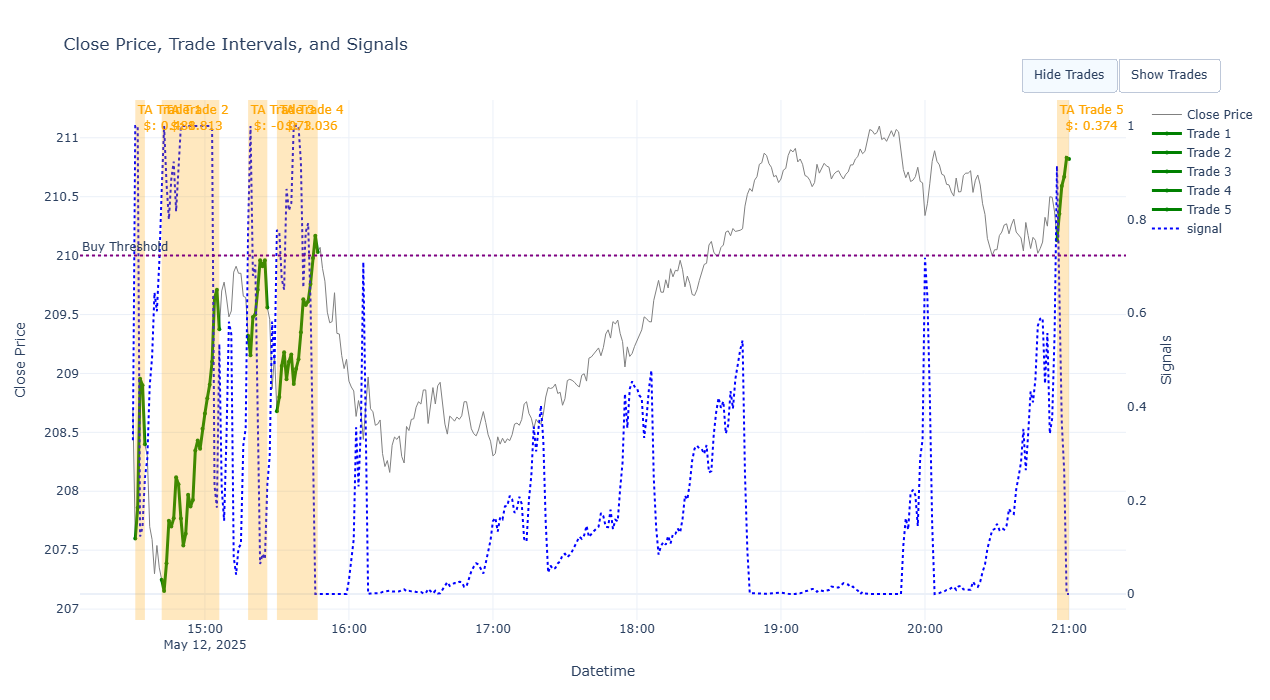


* Performance for 2025-05-12 *
  Buy & Hold Return ($): 1.815
  Strategy Return ($): 3.636
  Trades Returns ($): [0.488, 1.813, -0.073, 1.036, 0.374]

=== Processing trading day 2025-05-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


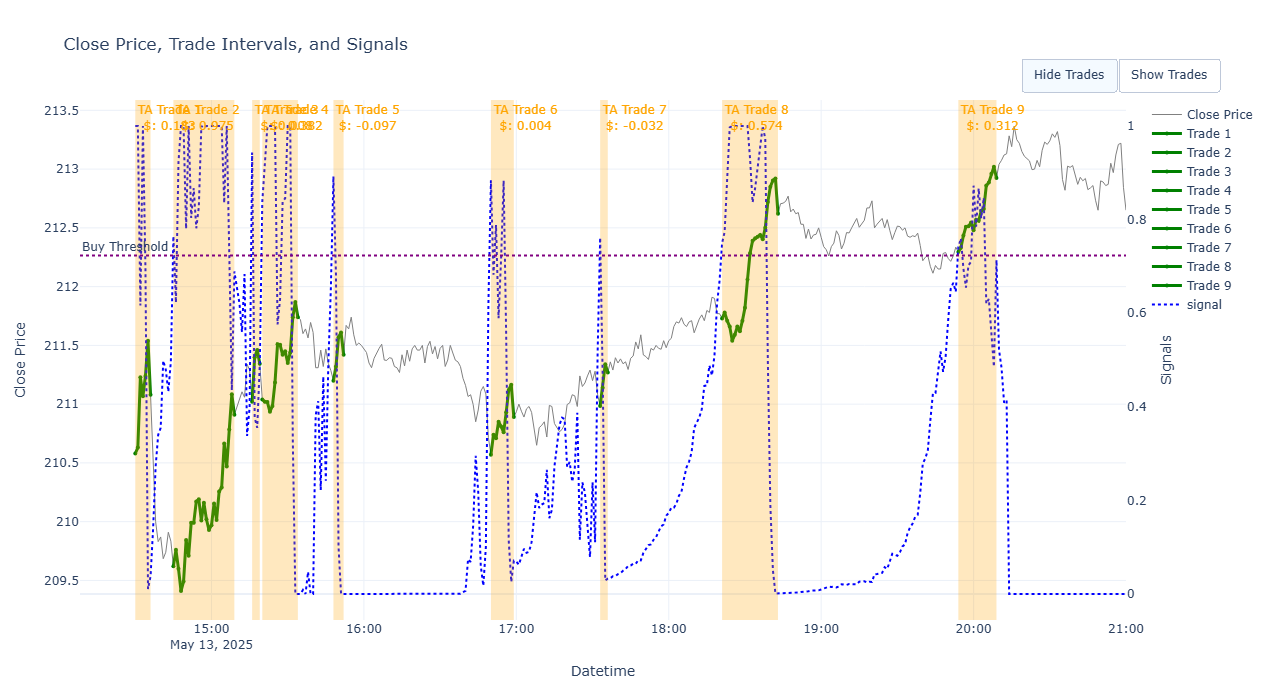


* Performance for 2025-05-13 *
  Buy & Hold Return ($): 1.753
  Strategy Return ($): 2.31
  Trades Returns ($): [0.183, 0.975, 0.008, 0.382, -0.097, 0.004, -0.032, 0.574, 0.312]

=== Processing trading day 2025-05-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


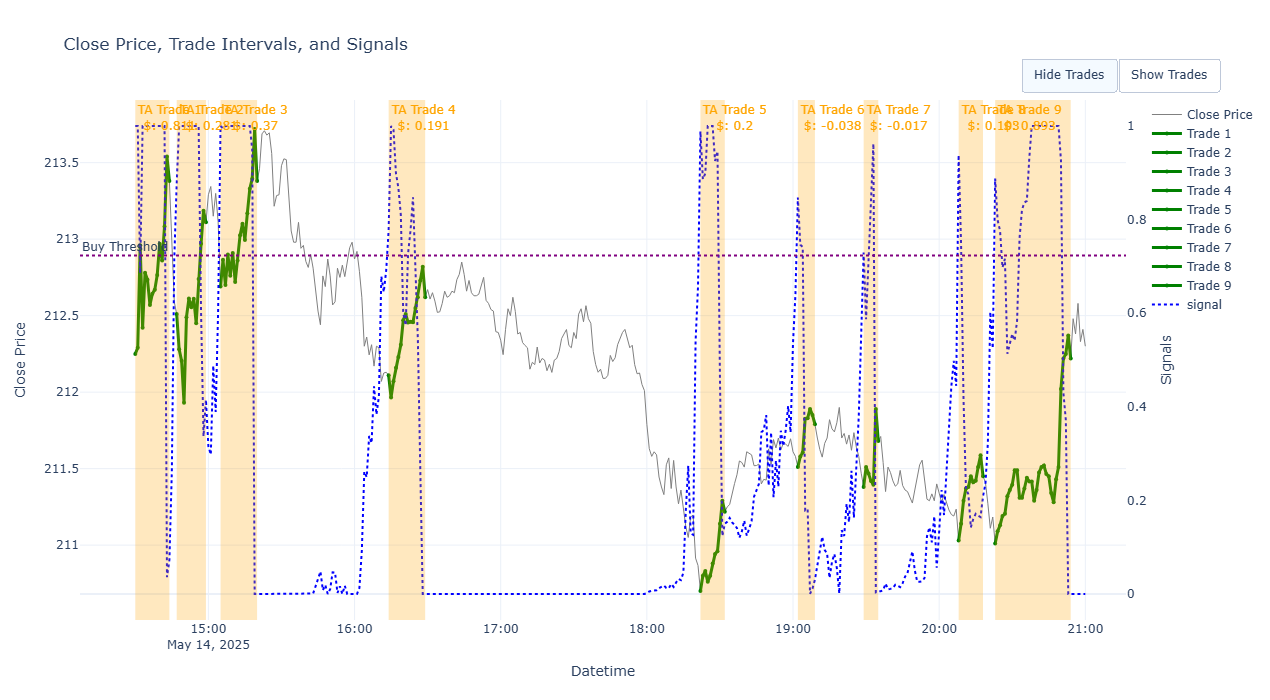


* Performance for 2025-05-14 *
  Buy & Hold Return ($): -0.268
  Strategy Return ($): 2.796
  Trades Returns ($): [0.811, 0.281, 0.37, 0.191, 0.2, -0.038, -0.017, 0.103, 0.893]

=== Processing trading day 2025-05-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


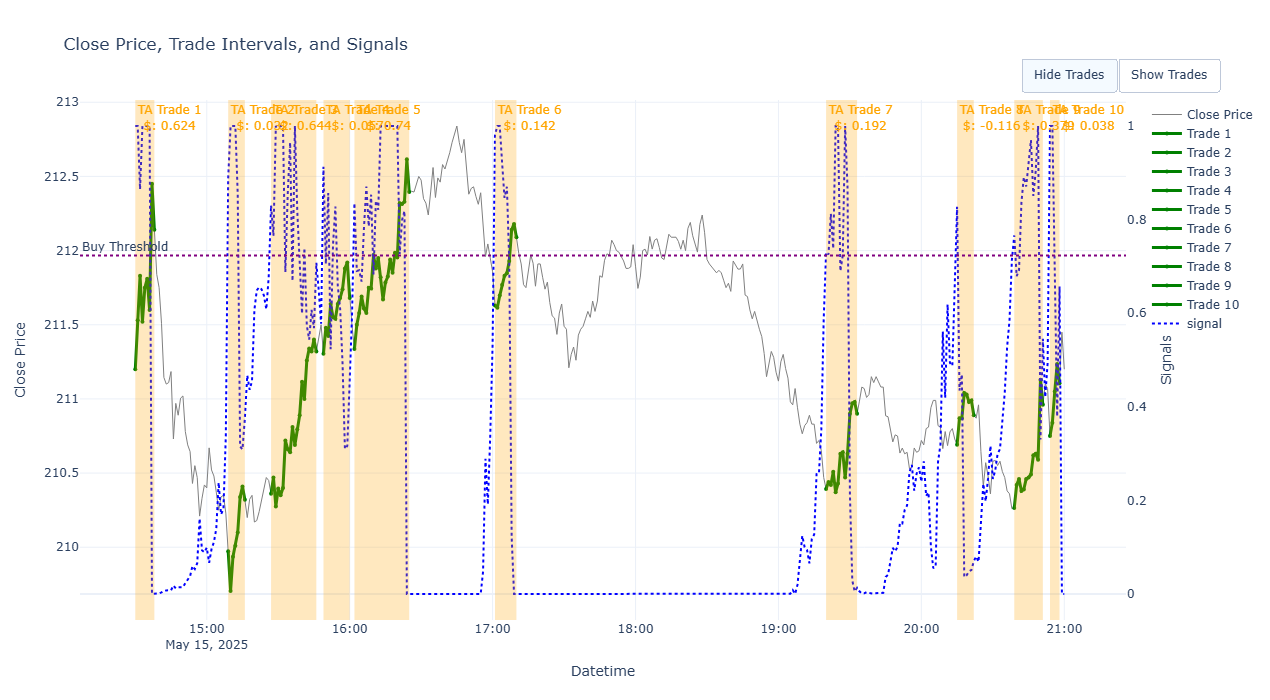


* Performance for 2025-05-15 *
  Buy & Hold Return ($): -0.317
  Strategy Return ($): 2.731
  Trades Returns ($): [0.624, 0.032, 0.644, 0.057, 0.74, 0.142, 0.192, -0.116, 0.379, 0.038]

=== Processing trading day 2025-05-16 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


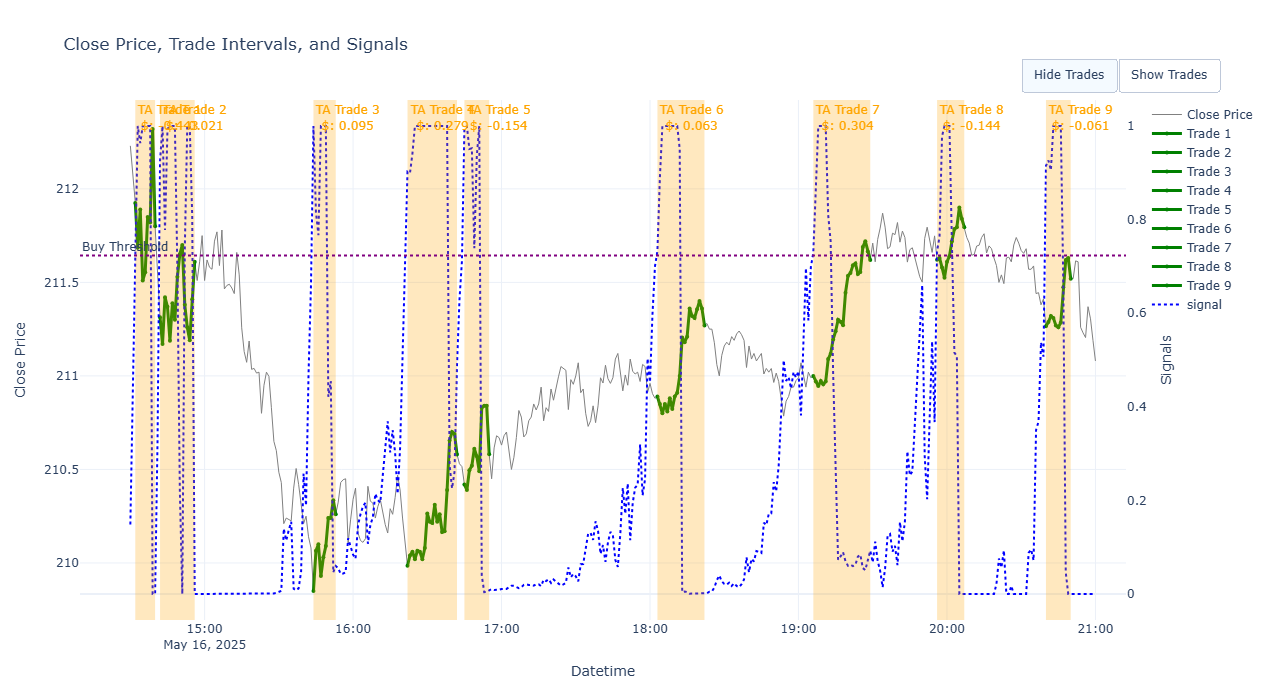


* Performance for 2025-05-16 *
  Buy & Hold Return ($): -1.468
  Strategy Return ($): -0.082
  Trades Returns ($): [-0.443, -0.021, 0.095, 0.279, -0.154, 0.063, 0.304, -0.144, -0.061]

=== Processing trading day 2025-05-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


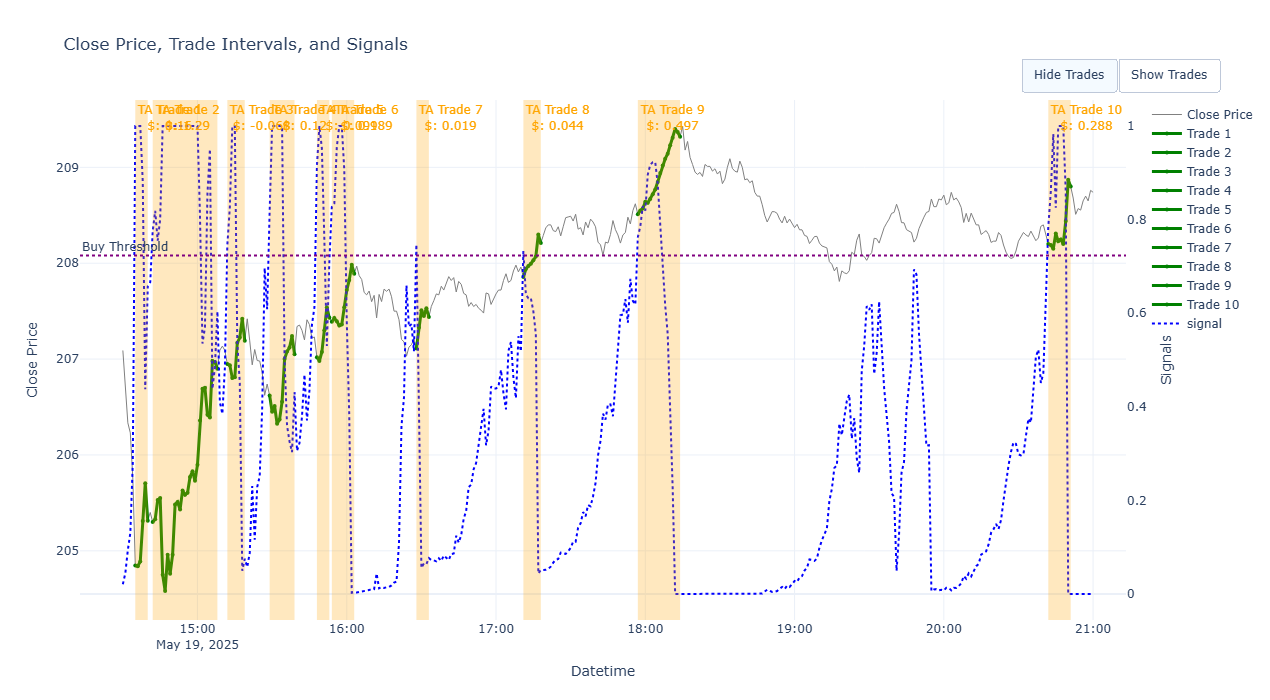


* Performance for 2025-05-19 *
  Buy & Hold Return ($): 1.338
  Strategy Return ($): 2.636
  Trades Returns ($): [0.16, 1.29, -0.068, 0.12, 0.099, 0.189, 0.019, 0.044, 0.497, 0.288]

=== Processing trading day 2025-05-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


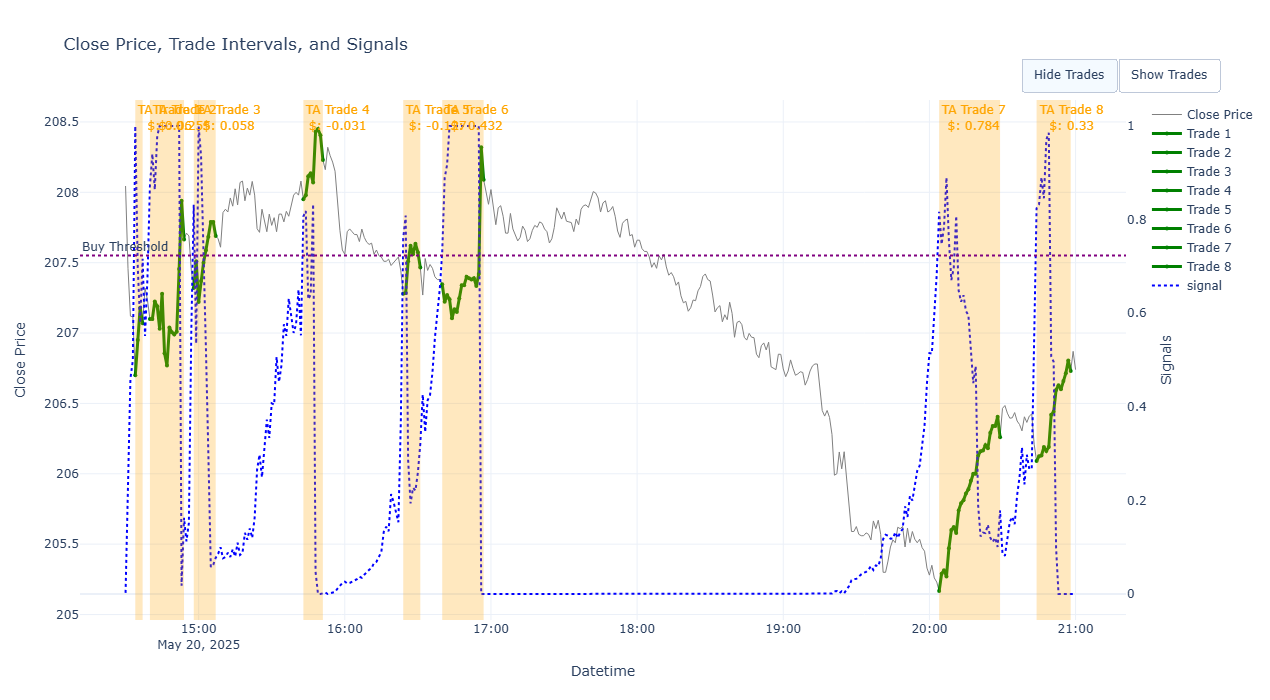


* Performance for 2025-05-20 *
  Buy & Hold Return ($): -1.616
  Strategy Return ($): 1.76
  Trades Returns ($): [0.06, 0.255, 0.058, -0.031, -0.127, 0.432, 0.784, 0.33]

=== Processing trading day 2025-05-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


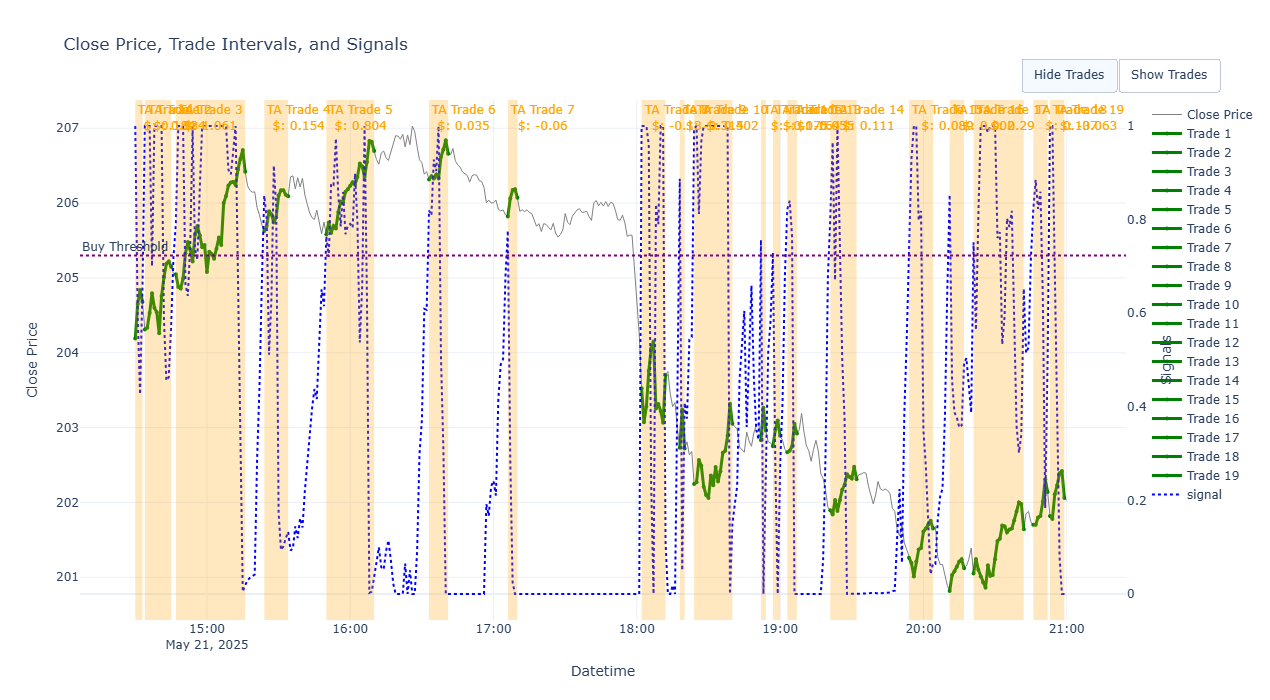


* Performance for 2025-05-21 *
  Buy & Hold Return ($): -2.465
  Strategy Return ($): 2.942
  Trades Returns ($): [0.184, 0.534, 1.061, 0.154, 0.804, 0.035, -0.06, -0.13, -0.314, 0.502, -0.175, -0.164, -0.055, 0.111, 0.089, 0.002, 0.29, 0.137, -0.063]

=== Processing trading day 2025-05-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


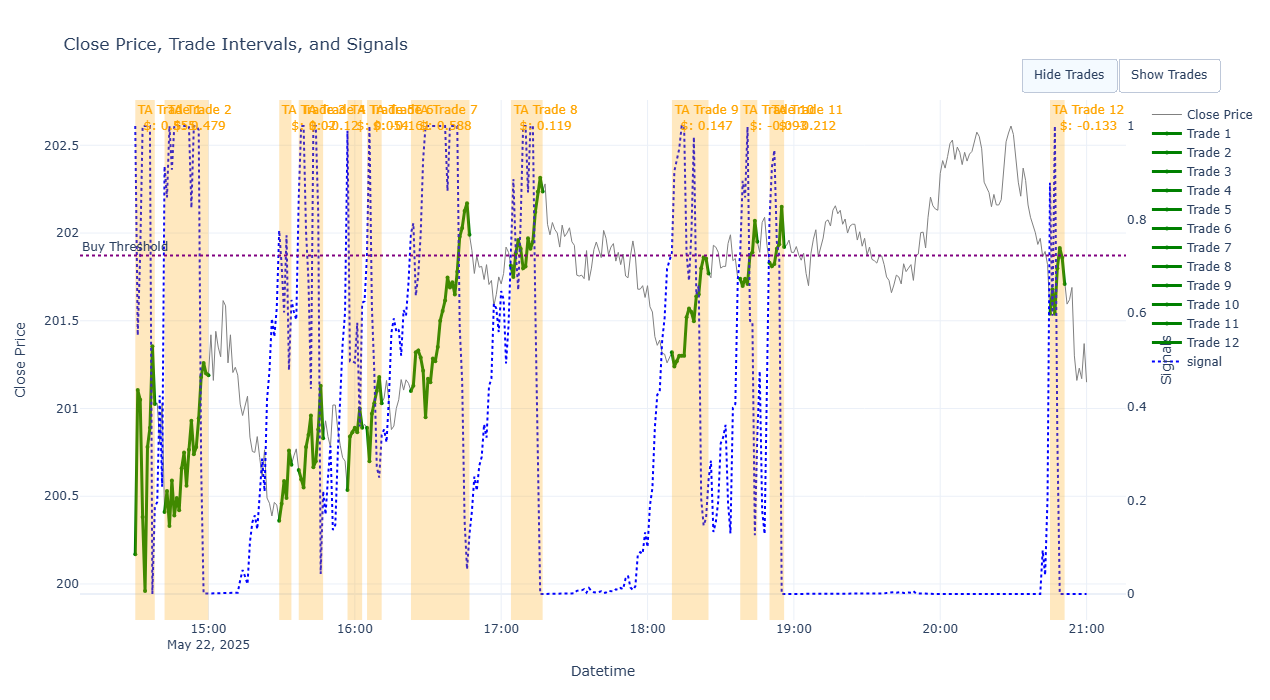


* Performance for 2025-05-22 *
  Buy & Hold Return ($): 0.679
  Strategy Return ($): 1.239
  Trades Returns ($): [0.555, 0.479, 0.02, -0.12, 0.054, -0.161, 0.588, 0.119, 0.147, -0.093, -0.212, -0.133]

=== Processing trading day 2025-05-23 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


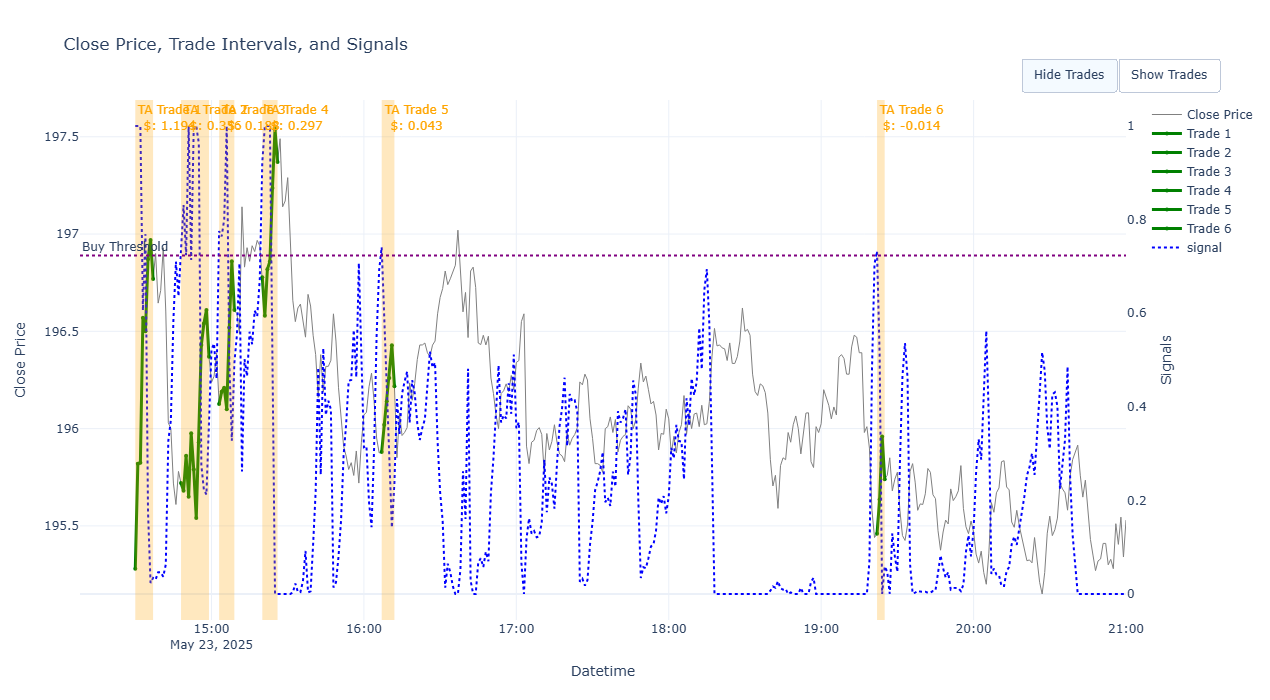


* Performance for 2025-05-23 *
  Buy & Hold Return ($): -0.043
  Strategy Return ($): 2.068
  Trades Returns ($): [1.194, 0.356, 0.188, 0.297, 0.043, -0.014]

=== Processing trading day 2025-05-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


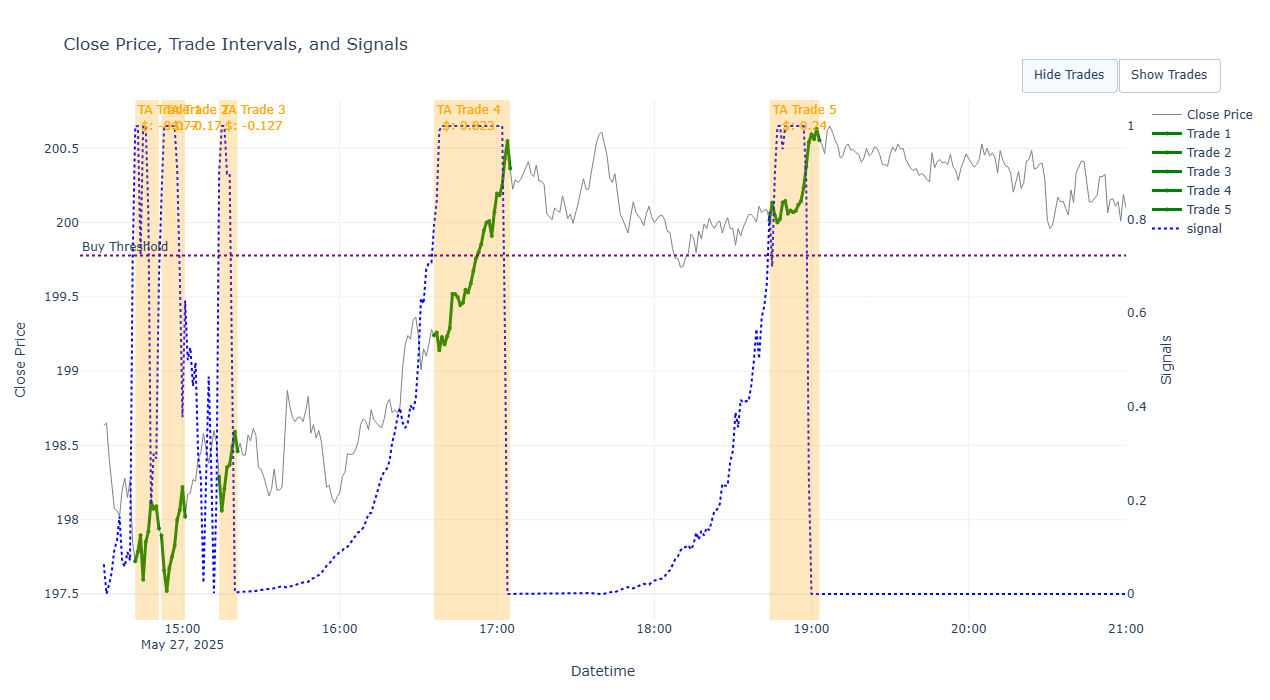


* Performance for 2025-05-27 *
  Buy & Hold Return ($): 1.166
  Strategy Return ($): 0.689
  Trades Returns ($): [-0.077, -0.17, -0.127, 0.823, 0.24]

=== Processing trading day 2025-05-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


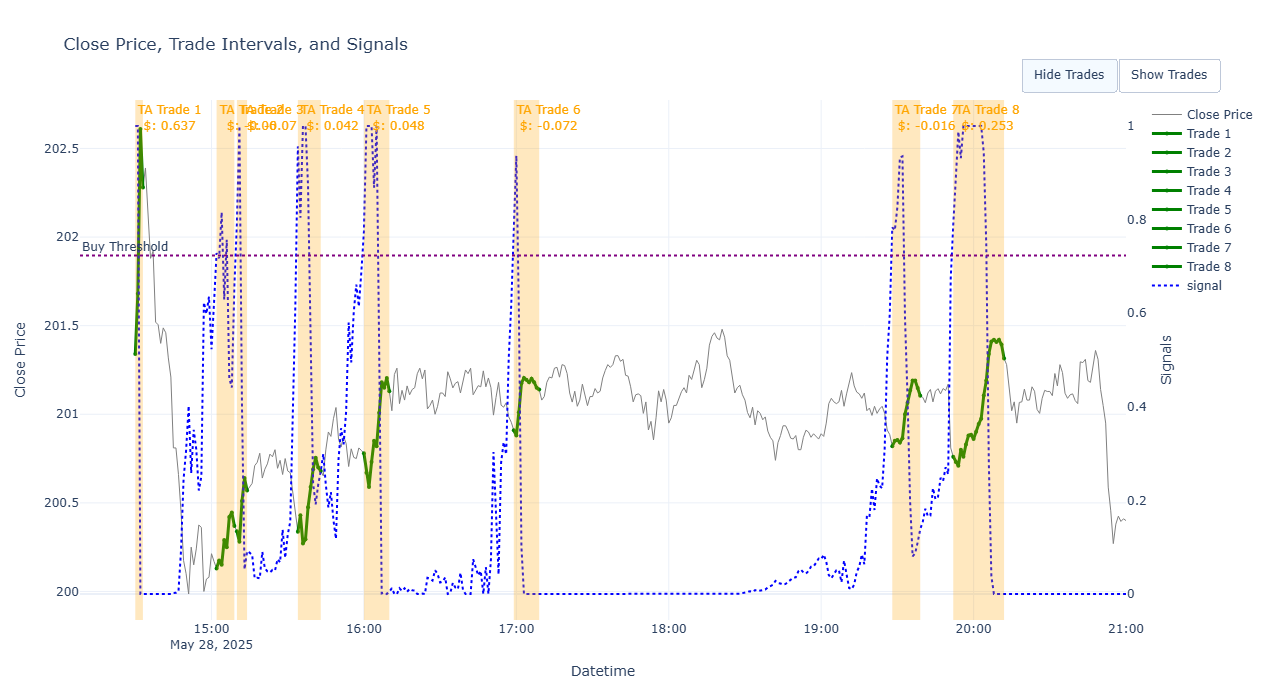


* Performance for 2025-05-28 *
  Buy & Hold Return ($): -1.241
  Strategy Return ($): 0.762
  Trades Returns ($): [0.637, -0.06, -0.07, 0.042, 0.048, -0.072, -0.016, 0.253]

=== Processing trading day 2025-05-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


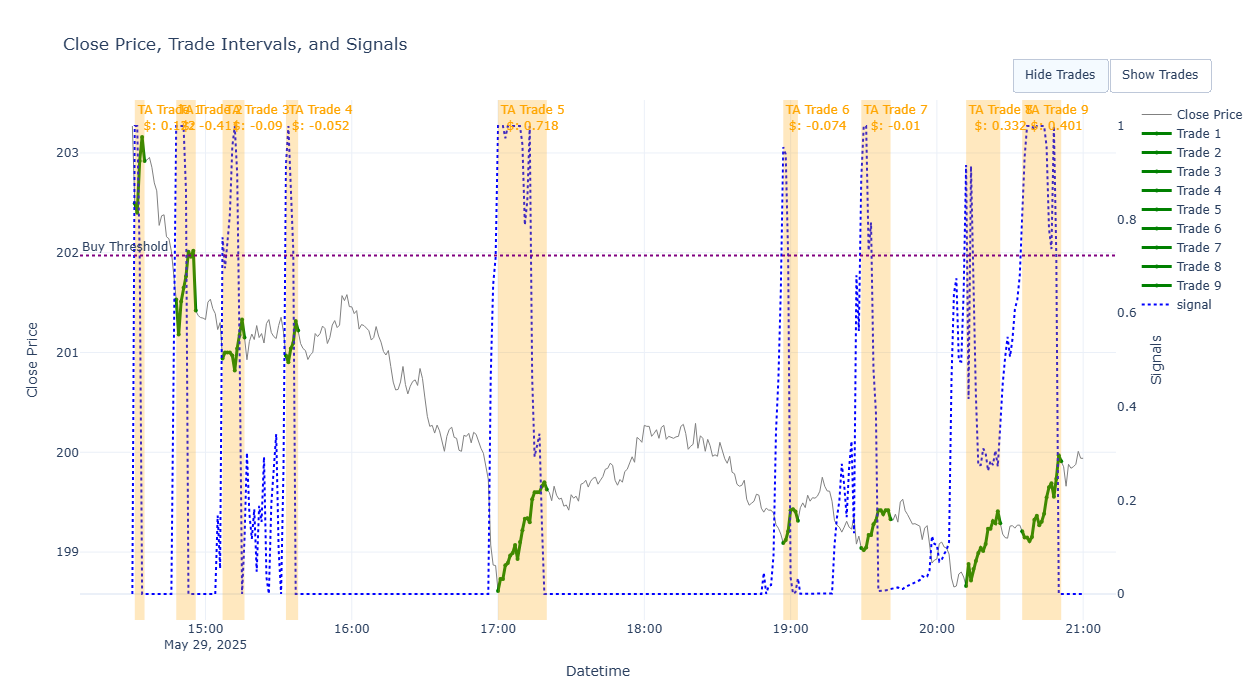


* Performance for 2025-05-29 *
  Buy & Hold Return ($): -3.633
  Strategy Return ($): 0.932
  Trades Returns ($): [0.122, -0.411, -0.09, -0.052, 0.718, -0.074, -0.01, 0.332, 0.401]

=== Processing trading day 2025-05-30 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


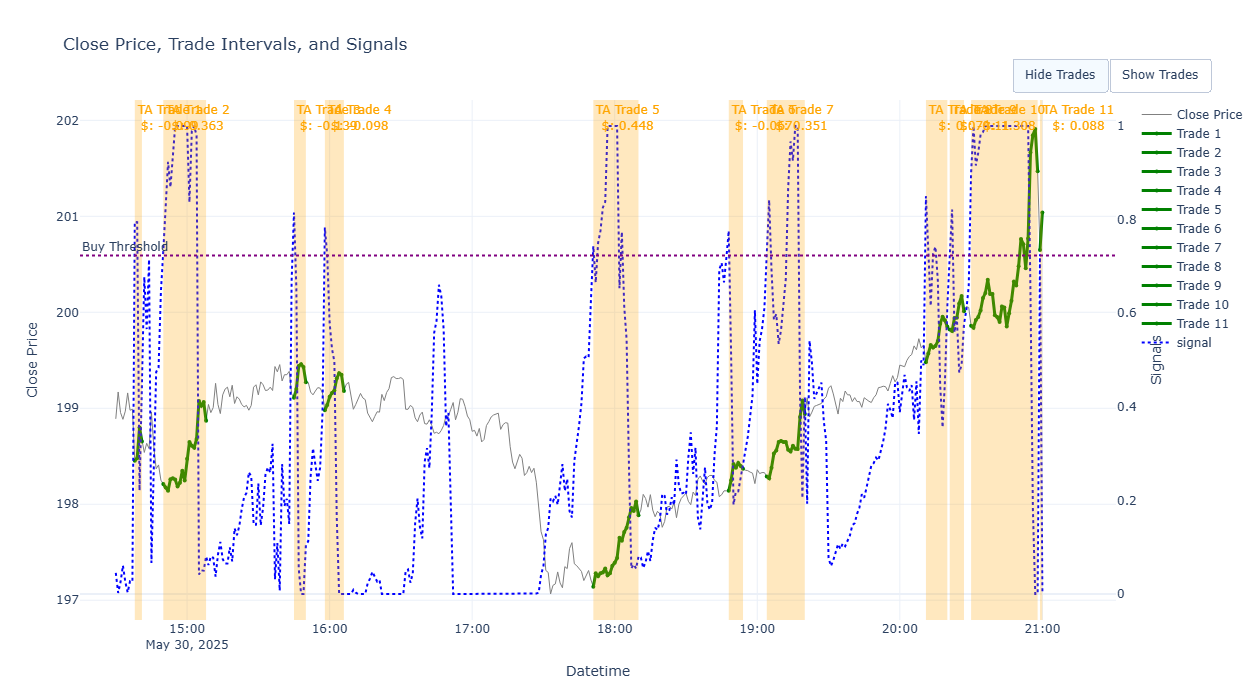


* Performance for 2025-05-30 *
  Buy & Hold Return ($): 1.85
  Strategy Return ($): 2.119
  Trades Returns ($): [-0.099, 0.363, -0.139, -0.098, 0.448, -0.067, 0.351, 0.07, -0.11, 1.308, 0.088]

Overall Summary (2025-05-01 = 210.8680 → 2025-05-30 = 200.8892)

One-time buy&hold gain: -9.979
Buy & Hold – each day ($): -7.992
Strategy Return ($): 54.658
Trades Count: 208
Strategy return per trade: 0.263
Num. trading days: 21
Strategy return per trading day: 2.603


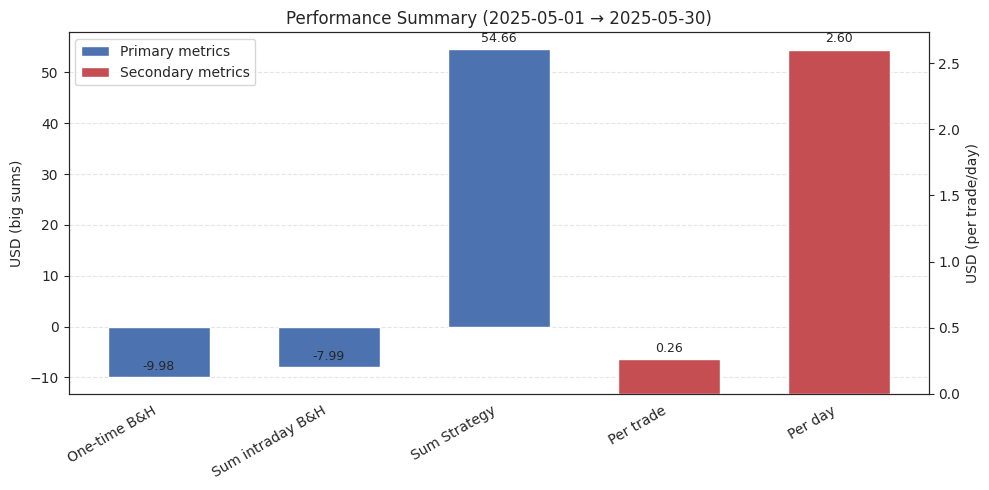


Full‐run mode
• Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …

Full‐period performance:

Overall Summary (2004-01-02 = 0.7731 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 195.620
Buy & Hold – each day ($): -385.278
Strategy Return ($): 3894.812
Trades Count: 53885
Strategy return per trade: 0.072
Num. trading days: 5400
Strategy return per trading day: 0.721


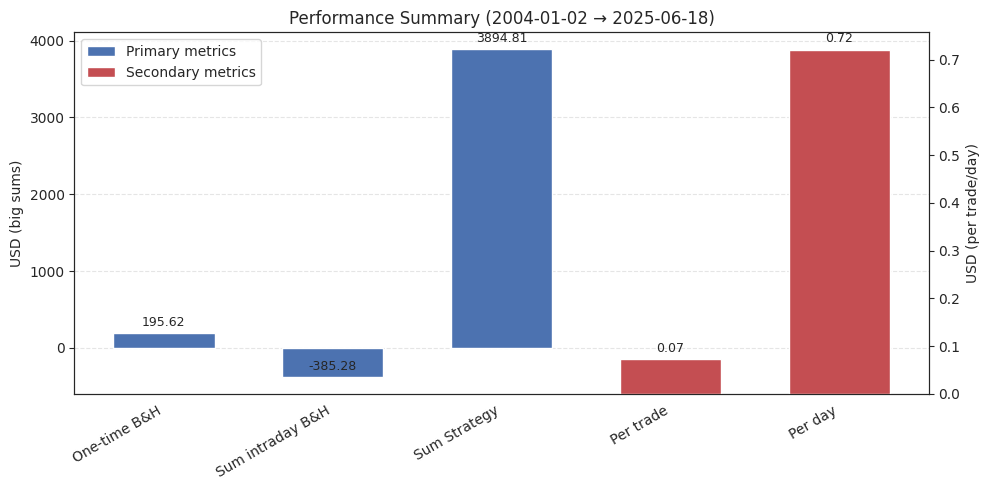


Test‐period performance:

Overall Summary (2022-03-28 = 172.8295 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 23.563
Buy & Hold – each day ($): -189.487
Strategy Return ($): 1898.737
Trades Count: 7165
Strategy return per trade: 0.265
Num. trading days: 810
Strategy return per trading day: 2.344


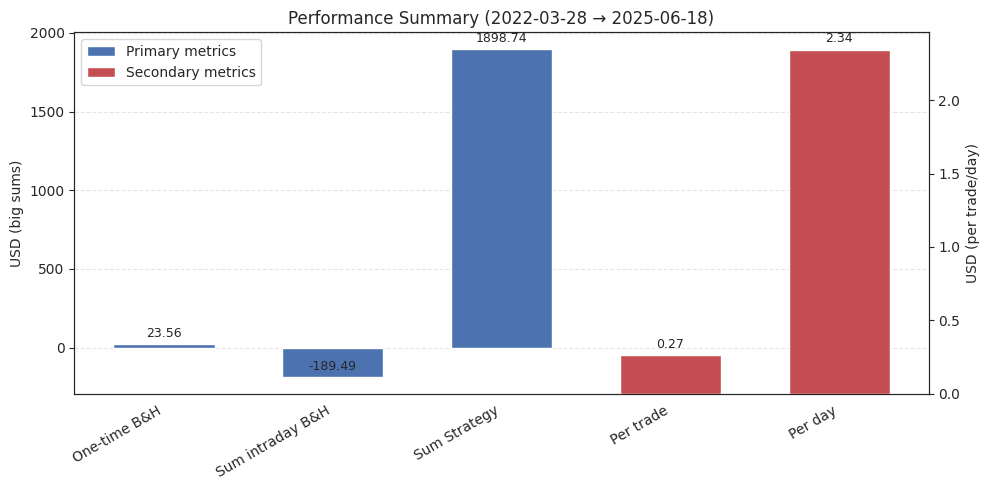


• Saving signals CSV …
Saved to dfs_training/AAPL_2_sign.csv


open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         bid         ask  StrategyEarning  \
2004-01-02 09:00:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:01:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:02:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:03:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:04:00     28000.0    0.763714    0.764857            0.000   
...                         ...         ...         ...              ...   
2025-06-18 20:56:00    385695.0  196.667400  196.962600            2.757   
2025-06-18 20:57:00    460630.0  196.527500  196.822500            2.757   
2025-06-18 20:58:00    525245.0  196.522500  196.817500            2.757   
2025-06-18 20:59:00   2075503.0  196.092800  196.387200            2.757   
2025-06-18 21:00:00  15600625.0  196.392600  196.687400            2.757   

                     EarningDiff        signal  signal_action  
2004-01-02 09:00:00        0.000  8.391716e-11              0  
2004-01-02 09:01:00        0.000  9.060815e-11              0  
2004-01-02 09:02:00        0.000  9.783265e-11              0  
2004-01-02 09:03:00        0.000  1.056332e-10              0  
2004-01-02 09:04:00        0.000  1.140557e-10              0  
...                          ...           ...            ...  
2025-06-18 20:56:00        2.157  0.000000e+00              0  
2025-06-18 20:57:00        2.296  0.000000e+00              0  
2025-06-18 20:58:00        2.301  0.000000e+00              0  
2025-06-18 20:59:00        2.731  0.000000e+00              0  
2025-06-18 21:00:00        2.431  0.000000e+00              0  

[3893400 rows x 11 columns]

In [29]:
df_fin = saveDF_checkDAY(
                        df=df,
                        hyperparams=best_params
                        )

df_fin

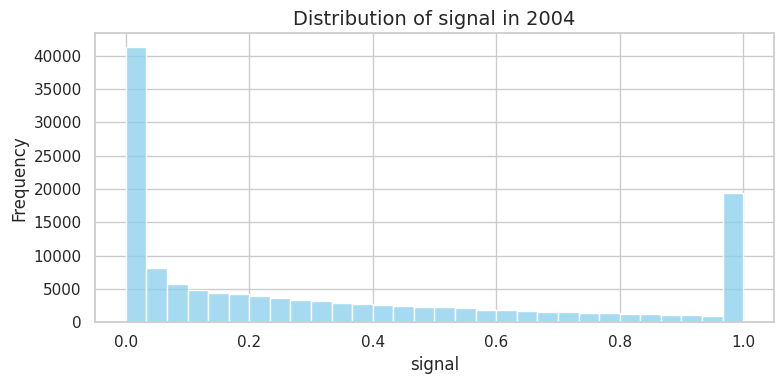

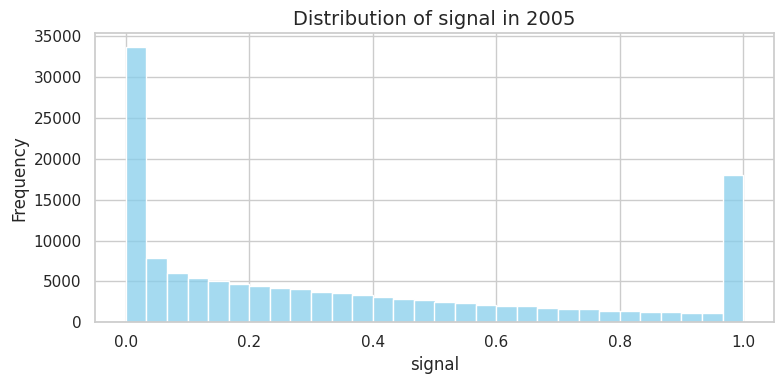

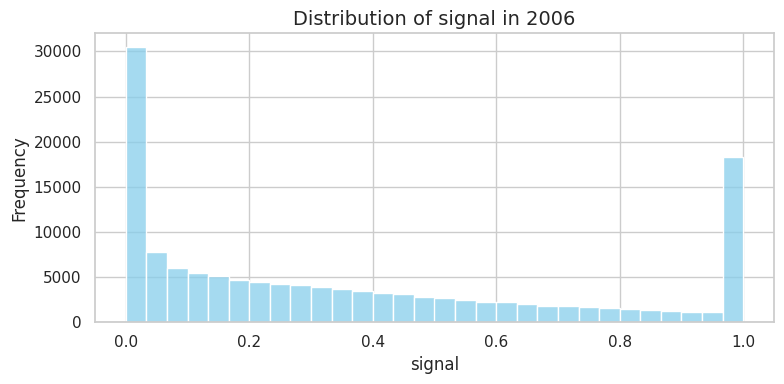

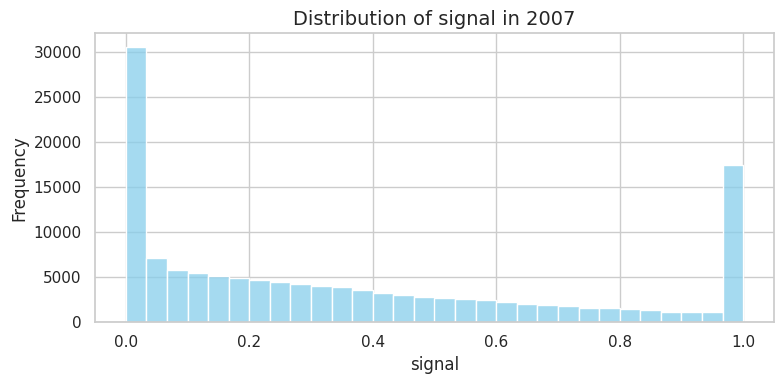

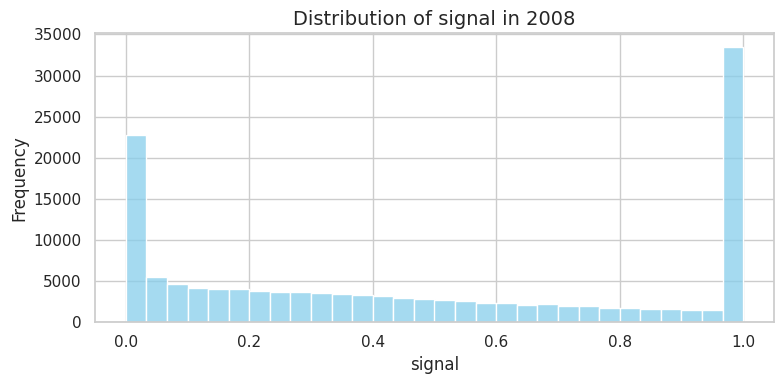

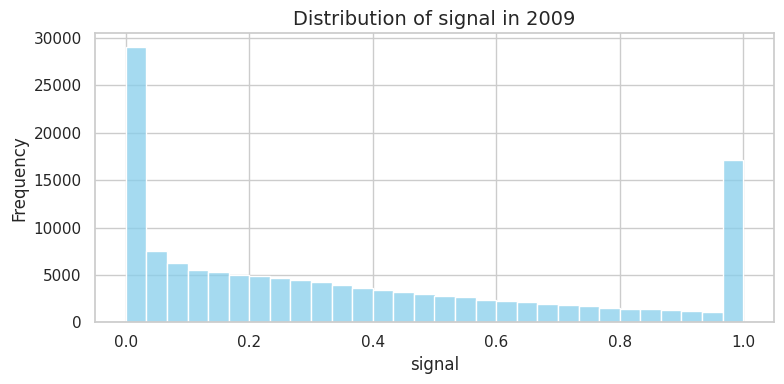

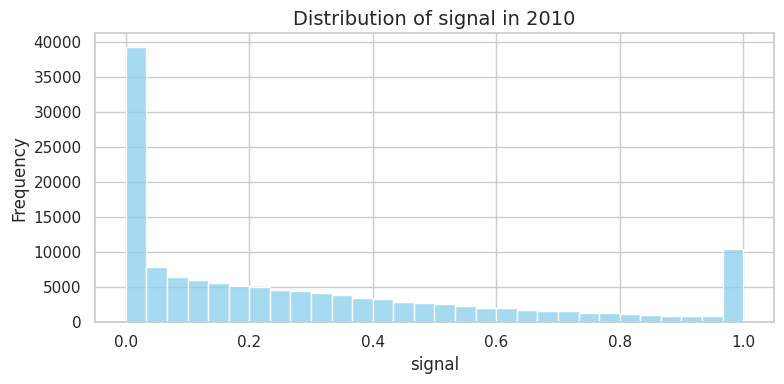

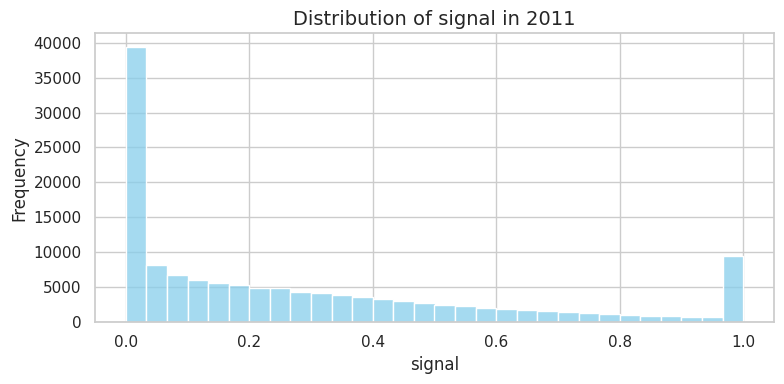

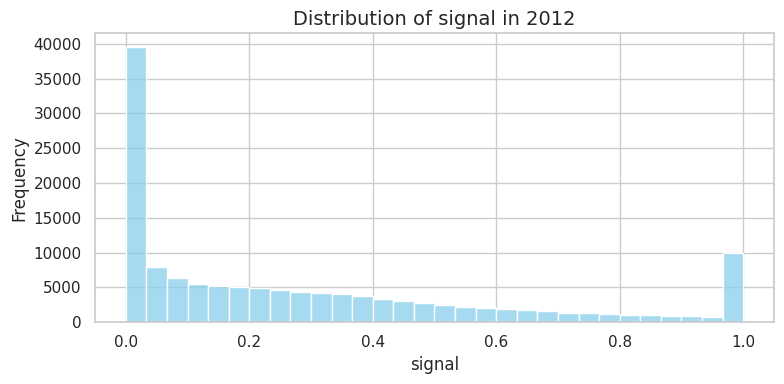

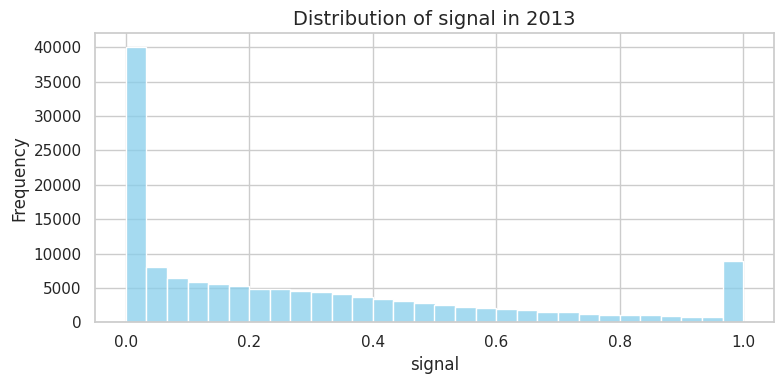

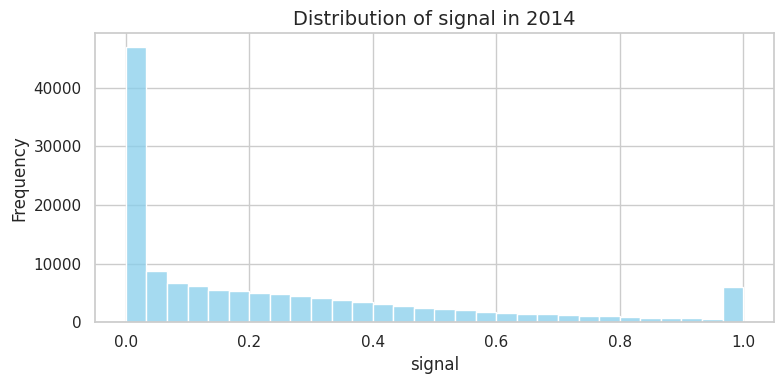

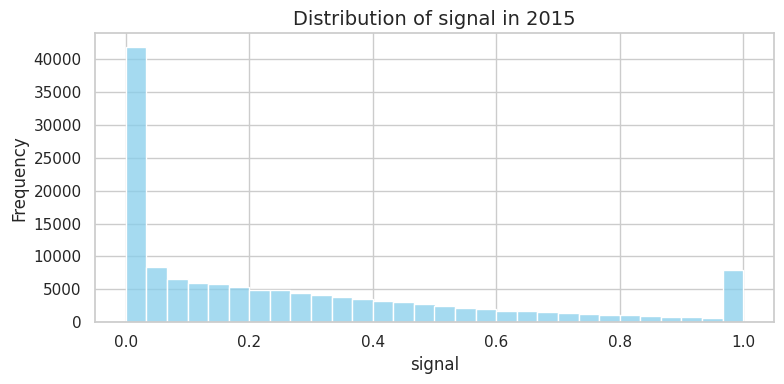

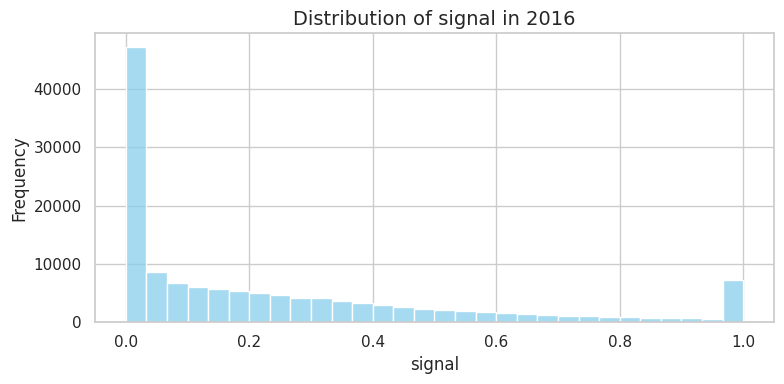

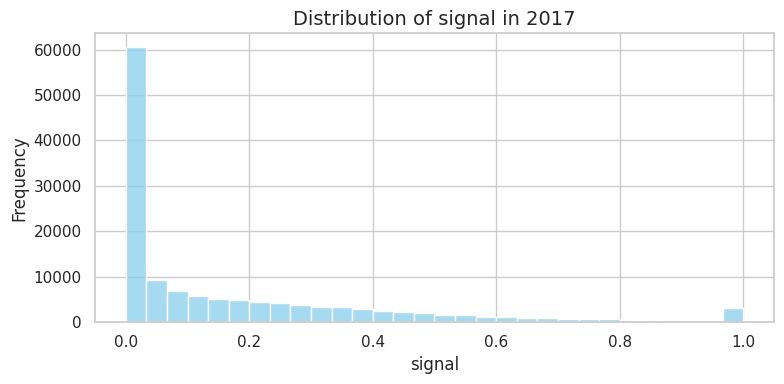

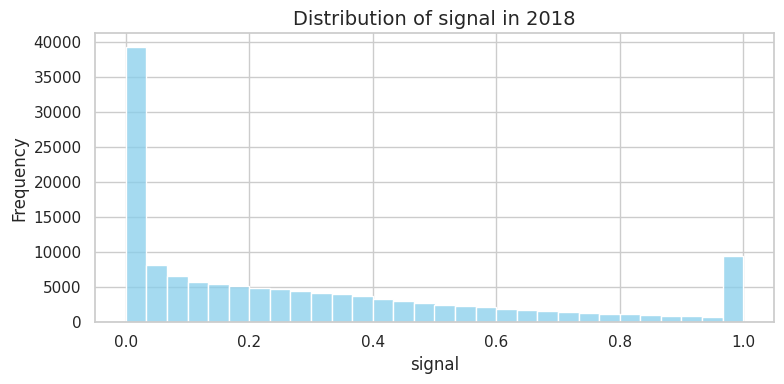

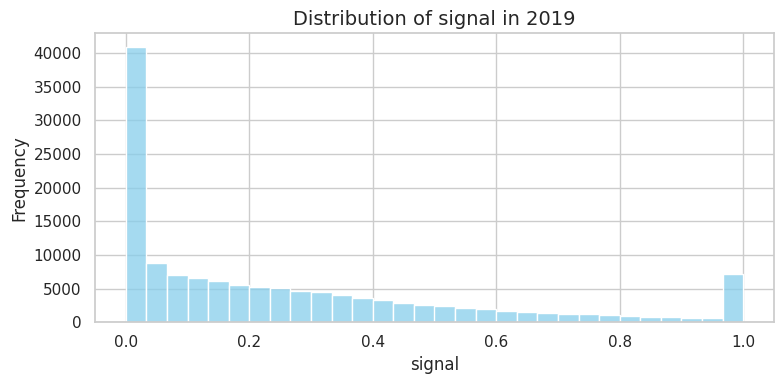

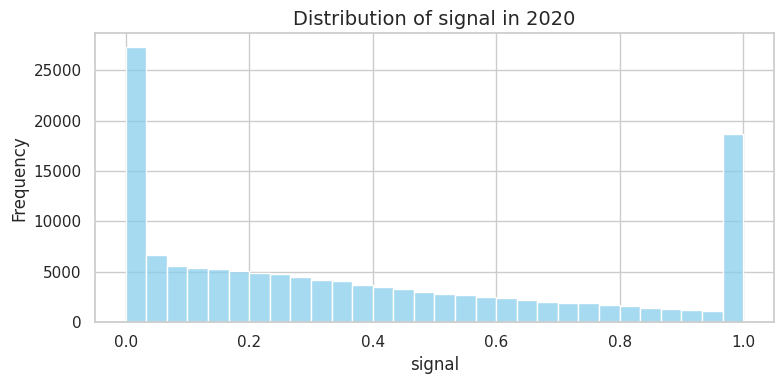

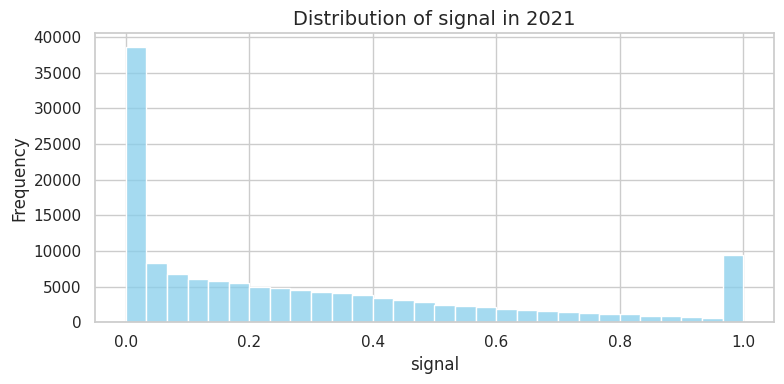

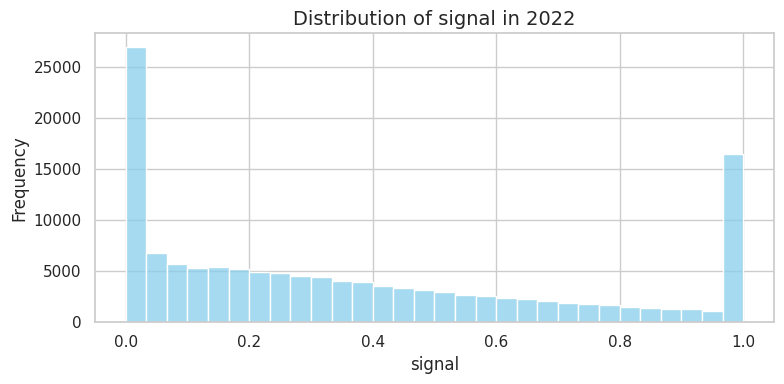

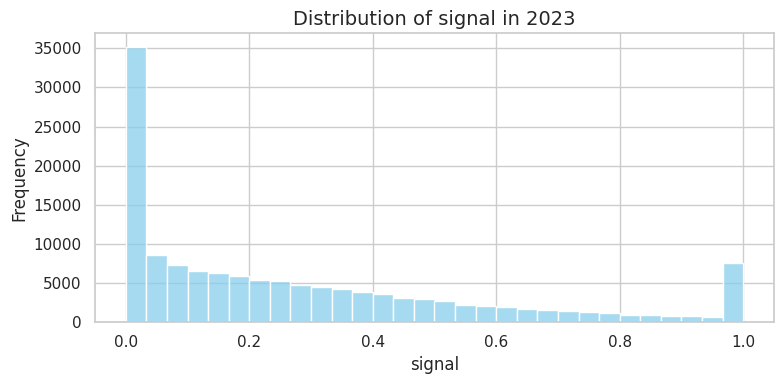

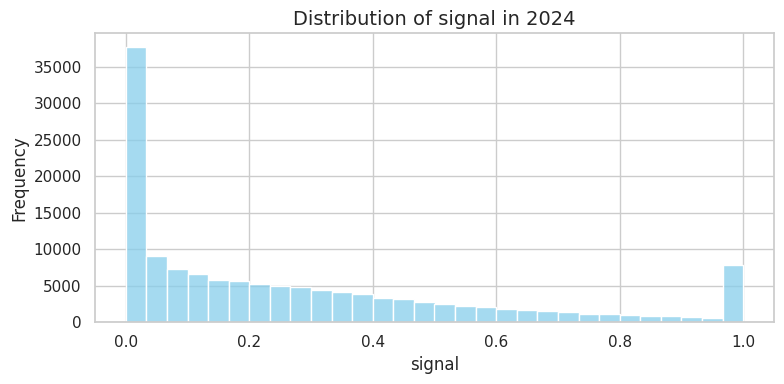

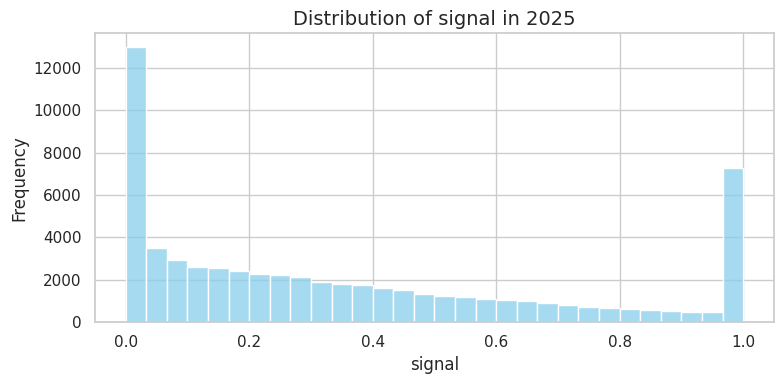

signal_min  signal_max  signal_mean  signal_median  close_return
2004-01         0.0         1.0     0.358615       0.211433      0.170916
2004-02         0.0         1.0     0.297914       0.151784      0.105893
2004-03         0.0         1.0     0.355170       0.213621      0.196335
2004-04         0.0         1.0     0.330360       0.179266      0.156863
2004-05         0.0         1.0     0.339688       0.185996      0.127743
2004-06         0.0         1.0     0.331787       0.176992      0.241579
2004-07         0.0         1.0     0.353595       0.218276      0.161862
2004-08         0.0         1.0     0.343399       0.181181      0.182185
2004-09         0.0         1.0     0.327267       0.182841      0.145439
2004-10         0.0         1.0     0.365369       0.237080      0.409440
2004-11         0.0         1.0     0.344454       0.201145      0.333589
2004-12         0.0         1.0     0.328442       0.208153      0.101071
2005-01         0.0         1.0     0.391638       0.274088      0.243334
2005-02         0.0         1.0     0.384241       0.276925      1.067515
2005-03         0.0         1.0     0.364330       0.253645      0.160576
2005-04         0.0         1.0     0.412069       0.306574      0.295820
2005-05         0.0         1.0     0.348784       0.232089      0.234620
2005-06         0.0         1.0     0.321302       0.197259      0.145751
2005-07         0.0         1.0     0.335761       0.220496      0.222039
2005-08         0.0         1.0     0.291709       0.168552      0.143297
2005-09         0.0         1.0     0.324413       0.207705      0.183041
2005-10         0.0         1.0     0.422573       0.318458      0.233241
2005-11         0.0         1.0     0.357469       0.251862      0.246400
2005-12         0.0         1.0     0.326179       0.225669      0.112209
2006-01         0.0         1.0     0.428396       0.326480      0.216178
2006-02         0.0         1.0     0.408206       0.297542      0.213435
2006-03         0.0         1.0     0.368324       0.264107      0.212021
2006-04         0.0         1.0     0.387281       0.287860      0.185997
2006-05         0.0         1.0     0.357323       0.248994      0.247914
2006-06         0.0         1.0     0.380296       0.283057      0.137473
2006-07         0.0         1.0     0.388779       0.287457      0.358532
2006-08         0.0         1.0     0.381830       0.280397      0.123615
2006-09         0.0         1.0     0.371289       0.281021      0.150496
2006-10         0.0         1.0     0.311073       0.206321      0.136044
2006-11         0.0         1.0     0.327587       0.223950      0.205850
2006-12         0.0         1.0     0.327968       0.212466      0.199142
2007-01         0.0         1.0     0.370514       0.277597      0.192073
2007-02         0.0         1.0     0.284308       0.172100      0.094767
2007-03         0.0         1.0     0.288411       0.181717      0.154442
2007-04         0.0         1.0     0.275984       0.160808      0.167337
2007-05         0.0         1.0     0.328618       0.236863      0.238485
2007-06         0.0         1.0     0.366795       0.275041      0.102931
2007-07         0.0         1.0     0.381187       0.281381      0.245818
2007-08         0.0         1.0     0.452747       0.369520      0.247318
2007-09         0.0         1.0     0.388585       0.300677      0.193898
2007-10         0.0         1.0     0.375229       0.279174      0.244270
2007-11         0.0         1.0     0.480084       0.418567      0.274720
2007-12         0.0         1.0     0.385648       0.301042      0.151206
2008-01         0.0         1.0     0.499429       0.440422      0.585735
2008-02         0.0         1.0     0.445294       0.368340      0.186676
2008-03         0.0         1.0     0.493378       0.430734      0.233486
2008-04         0.0         1.0     0.439872       0.370527      0.233614
2008-05         0.0         1.0     0.385038       0.305058      0.112945
2008-06      

In [7]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
